In [1]:
import ee
import google.auth

# Authenticate (if not already done)
ee.Authenticate()

# Get default credentials
credentials, _ = google.auth.default()

# Initialize Earth Engine with your project ID
ee.Initialize(credentials, project="earth-453917")  # Replace with your actual project ID

# Test if authentication works
#print(ee.ImageCollection("COPERNICUS/S2").size().getInfo())  # Should return number of images


🛰️ Found 6 Sentinel-2 images captured in 2023-06.
🗓️ Sentinel-2 Image Captured On: 2023-06-03


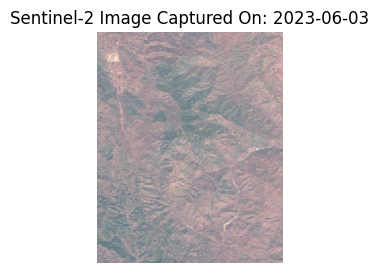

🗓️ Sentinel-2 Image Captured On: 2023-06-08


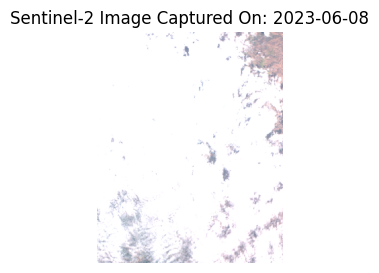

🗓️ Sentinel-2 Image Captured On: 2023-06-13


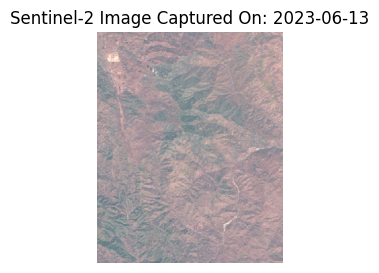

🗓️ Sentinel-2 Image Captured On: 2023-06-18


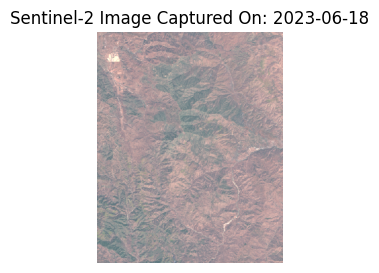

🗓️ Sentinel-2 Image Captured On: 2023-06-23


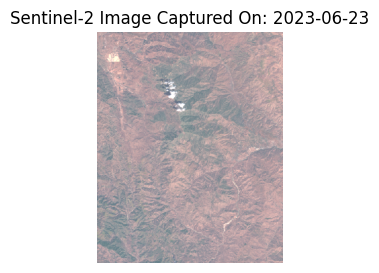

🗓️ Sentinel-2 Image Captured On: 2023-06-28


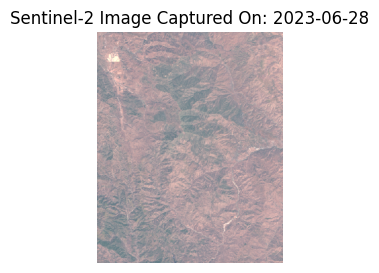

In [ ]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Define Area of Interest (AOI)
aoi = ee.Geometry.Rectangle([-121.5, 37.2, -121.3, 37.4])  # Define the bounding box

# Define Date Range for the Month
start_date = "2023-06-01"
end_date = "2023-06-30"

# Fetch ALL Sentinel-2 images available during the month
sentinel2 = ee.ImageCollection("COPERNICUS/S2") \
    .filterBounds(aoi) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .sort("system:time_start")  # Sort images by date (oldest first)

# Convert collection into a list
image_list = sentinel2.toList(sentinel2.size())  # Convert to list
num_images = image_list.size().getInfo()  # Get total number of images

print(f"🛰️ Found {num_images} Sentinel-2 images captured in {start_date[:7]}.")

# Loop through all images in the month
for i in range(num_images):
    image = ee.Image(image_list.get(i))  # Get the image at index `i`

    # Get the capture date
    image_date = ee.Date(image.get("system:time_start")).format("YYYY-MM-dd").getInfo()
    print(f"🗓️ Sentinel-2 Image Captured On: {image_date}")

    # Select RGB bands
    image_rgb = image.select(['B4', 'B3', 'B2'])

    # Request download URL
    url = image_rgb.getDownloadURL({'scale': 50, 'region': aoi, 'format': 'NPY'})

    # Fetch Image as NumPy Array
    response = requests.get(url)
    np_image = np.load(BytesIO(response.content))

    # Extract and stack Sentinel-2 RGB bands correctly
    np_image = np.array([np_image['B4'], np_image['B3'], np_image['B2']])  # Extract bands
    np_image = np.transpose(np_image, (1, 2, 0))  # Rearrange to (H, W, 3)

    # Convert to float32 for proper normalization
    np_image = np_image.astype(np.float32)

    # Normalize Image
    min_val, max_val = 500, 3000
    np_image = np.clip((np_image - min_val) / (max_val - min_val), 0, 1)

    # Display Image
    plt.figure(figsize=(3, 3))
    plt.imshow(np_image)
    plt.axis("off")
    plt.title(f"Sentinel-2 Image Captured On: {image_date}")
    plt.show()


In [3]:
data = pd.read_csv('image.csv')

In [4]:
data = data[['latitude', 'longitude' , 'acq_date']]

In [9]:
import ee
import pandas as pd
import numpy as np
from datetime import timedelta
import requests
from io import BytesIO


# Assume "data" is a large DataFrame containing wildfire records
data['acq_date'] = pd.to_datetime(data['acq_date'])

# Randomly sample 100 wildfire locations
sampled_data = data.sample(n=5, random_state=42).reset_index(drop=True)

# Sentinel-2 Bands to Extract (12 bands)
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Define Patch Size (e.g., 32x32 pixels)
patch_size = 32
scale = 10  # Sentinel-2 resolution in meters

# Create an empty list to store extracted patches
valid_patches = []

# Loop through each randomly selected wildfire location
for index, row in sampled_data.iterrows():
    lat, lon, wildfire_date = row['latitude'], row['longitude'], row['acq_date']

    # Define Area of Interest (NxN window centered at wildfire location)
    aoi = ee.Geometry.Point([lon, lat]).buffer(scale * patch_size / 2).bounds()

    # Fetch Sentinel-2 images before the wildfire event
    sentinel2 = (
        ee.ImageCollection("COPERNICUS/S2")
        .filterBounds(aoi)
        .filterDate((wildfire_date - timedelta(days=30)).strftime('%Y-%m-%d'), wildfire_date.strftime('%Y-%m-%d'))
        #.filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))  # Reduce cloudy images
        .sort("system:time_start", False)  # Sort by closest to wildfire_date first
    )

    # Get the first image as the closest before the wildfire date
    first_image = sentinel2.first()

    # Ensure we found an image
    if first_image.getInfo() is None:
        continue  # Skip this location if no images exist

    # Get the actual capture date of the first image
    first_image_date = ee.Date(first_image.get("system:time_start")).format("YYYY-MM-dd").getInfo()
    first_image_date = pd.to_datetime(first_image_date)

    # Generate the next 4 expected image dates (around every 5 days before)
    expected_dates = [first_image_date - timedelta(days=i * 3) for i in range(1, 3)]

    patch_sequence = [first_image]  # Store image objects
    valid = True  # Track if we successfully get all 5 images

    for target_date in expected_dates:
        try:
            # Find the closest image to the expected date (with a ±2-day range)
            closest_image = (
                sentinel2
                .filterDate((target_date - timedelta(days=2)).strftime('%Y-%m-%d'), (target_date + timedelta(days=2)).strftime('%Y-%m-%d'))
                .sort("system:time_start", False)
                .first()
            )

            # Ensure an image exists
            if closest_image.getInfo() is None:
                valid = False  # Mark invalid if any step is missing
                break  # Stop processing this location

            # Append to sequence
            patch_sequence.append(closest_image)

        except Exception as e:
            valid = False  # Mark as invalid if any step fails
            break  # Stop processing this location

    if valid and len(patch_sequence) == 3:  # Ensure exactly 5 steps
        np_patches = []  # Store raw pixel data

        for img in patch_sequence:
            try:
                # Clip Image to AOI and Select Bands
                image_clipped = img.clip(aoi).select(bands)

                # Request Download URL
                url = image_clipped.getDownloadURL({'scale': scale, 'region': aoi, 'format': 'NPY'})

                # Fetch Image Patch as NumPy Array
                response = requests.get(url)
                response.raise_for_status()
                structured_array = np.load(BytesIO(response.content))

                # Convert structured array to standard NumPy format
                np_patch = np.stack([structured_array[band] for band in bands], axis=-1)  # (32, 32, 12)
                np_patches.append(np_patch)

            except Exception as e:
                valid = False
                break  # Stop processing if a single patch fails

        if valid:
            np_patches = np.array(np_patches)  # Final shape: (5, 32, 32, 12)

            # Store Patch Data
            valid_patches.append({
                'latitude': lat,
                'longitude': lon,
                'wildfire_date': wildfire_date.strftime('%Y-%m-%d'),
                'patch_data': np_patches  # Shape [5, 32, 32, 12]
            })

# Convert results to a DataFrame
df_patches = pd.DataFrame(valid_patches)


In [10]:
df_patches.to_csv("sentinel2_patches.csv", index=False)

# Display the first few rows
print(df_patches)

   latitude  longitude wildfire_date  \
0  33.35200 -100.81268    2023-11-12   
1  40.93549  -87.33327    2023-11-30   
2  38.06153  -93.99208    2023-12-11   
3  41.21888  -80.50996    2023-12-14   
4  38.93803 -112.81615    2023-05-21   

                                          patch_data  
0  [[[[2322 2065 2028 2051 2229 2696 2900 2890 31...  
1  [[[[3091 3101 2951 3218 3096 3255 3321 3452 34...  
2  [[[[2813 2411 2141 2171 2277 2436 2594 2560 28...  
3  [[[[2708 2291 2041 2079 2300 2393 2473 2246 25...  
4  [[[[3360 3082 3283 3730 4224 4375 4648 4070 47...  


In [ ]:
df_patches['patch_data'][0].shape

(3, 34, 34, 12)